### In this file, we simply repeat what we did in class_by_class.ipynb file multiple times to discover a more robust correlation between the entropy difference (of a subsample and its class) and the corresponding test set accuracy

In [1]:
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, DataLoader, SubsetRandomSampler, Subset, ConcatDataset
import os
from Truncate import truncate
from BSI_Entropy import BSIE
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_dir = './data/cifar10'
training_dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

#### Configuration

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [5]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [6]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [7]:
device = get_default_device()
device

device(type='cpu')

In [8]:
modelCNN = to_device(Cifar10CnnModel(), device)

In [9]:
modelCNN.load_state_dict(torch.load('cifar10-cnn.pth')) # load our pretrained model

<All keys matched successfully>

In [10]:
from torch.utils.data.dataloader import DataLoader
batch_size=128
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
evaluate(modelCNN, test_loader)

{'val_loss': 0.9372484087944031, 'val_acc': 0.7689453363418579}

In [11]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()

    return hook

In [12]:
modelCNN.network[18].register_forward_hook(get_features('18'))

In [13]:
img, label = training_dataset[0]
output = modelCNN(to_device(img.unsqueeze(0), device))
features['18']

tensor([[ -5.6519,  -6.5169,  -2.3042, -10.3155,  -6.2740,  -7.3530,  -9.4220,
          -7.6540,  -2.5881,  -5.9865,  -5.6165, -13.3802,  -7.1443,  -7.1914,
          10.6255, -15.4467,  13.3446,  -3.9516,  -4.5310,  -7.7378,   7.6724,
          -7.3328,   8.9874, -10.4525,  -4.5261,  21.3373,  -2.2587,   4.0662,
         -10.7542,  -9.9675, -16.7312, -11.5910,   3.9105,  -4.6706,   1.3064,
         -10.7250,  -2.0155,  -4.2895,  -4.0824,  -5.2736,  -4.3467,  -2.8592,
          -4.6779,  -5.3947,  -5.3260,  -3.7954,  -7.3469, -10.7469,   9.0206,
          -7.5153,  -6.2967, -11.4308,   6.1021,  -5.9107,  11.2416,  -7.5625,
         -15.8229,  -8.9783,   8.0090,  -6.7072,  -9.5007, -10.0275, -17.6930,
          -4.0522]])

#### Build the feature space of the entire training set

In [14]:
dataset_matrix = []

for i in range(len(training_dataset)):
    img, label = training_dataset[i]
    output = modelCNN(to_device(img.unsqueeze(0), device))
    dataset_matrix.append(features['18'])

#### SVD and BSEI of training set feature space

In [15]:
feature_space = torch.cat(dataset_matrix, dim = 0).T
print(feature_space)

tensor([[ -5.6519, -14.4451, -22.6971,  ..., -22.9344, -41.6881, -33.3670],
        [ -6.5169,  -1.8694,   6.1914,  ...,   6.1461,  30.5165,  16.6999],
        [ -2.3042,  -9.4996, -18.3538,  ..., -17.3936, -23.5260, -11.6376],
        ...,
        [-10.0275, -10.4702, -10.3386,  ..., -11.6350, -16.4754, -10.2969],
        [-17.6930, -13.3661, -10.6610,  ..., -12.2042, -17.8561, -13.9581],
        [ -4.0522,  -9.0408,  -8.6644,  ..., -12.1393, -15.2641, -11.7430]])


In [16]:
singular_values = torch.svd(feature_space)[1]
print(singular_values)

tensor([24029.2207,  8379.5000,  6230.4380,  5296.4209,  4423.2935,  3975.5259,
         3294.6665,  2758.4077,  2511.9285,  1702.8890,  1347.9779,  1096.4141,
          934.9056,   820.4958,   779.4859,   718.4184,   679.9614,   673.0159,
          617.0909,   605.8341,   574.9900,   532.4570,   508.4559,   483.6274,
          464.7852,   432.4646,   412.2122,   398.2830,   382.8516,   376.4213,
          367.9260,   352.3717,   336.9726,   328.7083,   312.1147,   308.6684,
          297.2871,   275.8092,   274.8790,   265.2029,   262.0873,   250.1465,
          247.1421,   236.4247,   223.3149,   218.1718,   216.1208,   211.7611,
          209.1635,   201.5703,   197.5894,   187.3112,   182.4898,   176.2399,
          173.9505,   167.2756,   165.1488,   160.2181,   155.9101,   150.0721,
          148.4122,   144.4359,   135.8520,   124.9880])


In [17]:
training_set_entropy = BSIE(singular_values).item()
training_set_entropy

0.06558703475578931

Entropy values of subsamples of the training set

In [19]:
def build_subsample_matrix(n_samples = 8000): # default value for one subsample is 8000

    subsample_matrix = []

    # Generate a random permutation of indices
    indices = torch.randperm(len(training_dataset))

    # Select the first 8000 indices to randomly select 5000 images
    selected_indices = indices[:n_samples]

    for j in selected_indices:
        #.item() function will return 1*1 PyTorch tensor to a number
        img, label = training_dataset[j.item()]
        output = modelCNN(to_device(img.unsqueeze(0), device))
        subsample_matrix.append(features['18'])

    subsample_matrix_T = torch.cat(subsample_matrix, dim = 0).T # subsample feature space
    singularValues = torch.svd(subsample_matrix_T)[1]
    

    return BSIE(singularValues).item(), torch.utils.data.Subset(training_dataset, selected_indices)

In [20]:
a, b = build_subsample_matrix()

In [21]:
a, len(b)

(0.06462979449098571, 8000)

In [22]:
dataset_matrix = []
for i in b:
    img, label = i
    output = modelCNN(to_device(img.unsqueeze(0), device))
    dataset_matrix.append(features['18'])

In [23]:
BSIE(torch.svd(torch.cat(dataset_matrix, dim = 0).T)[1]).item()

0.06462979449098571

In [24]:
list_entropy_subsample = [build_subsample_matrix() for i in range(1000)]
print(list_entropy_subsample)

[(0.06507503339112553, <torch.utils.data.dataset.Subset object at 0x00000270F8D3E390>), (0.06478894046014061, <torch.utils.data.dataset.Subset object at 0x00000270F8088ED0>), (0.06415357033914548, <torch.utils.data.dataset.Subset object at 0x00000270F8D3DA90>), (0.06634521518737402, <torch.utils.data.dataset.Subset object at 0x00000270E027CD50>), (0.06657208906022372, <torch.utils.data.dataset.Subset object at 0x00000270F8D3CD10>), (0.0657251459630801, <torch.utils.data.dataset.Subset object at 0x00000270F8CED090>), (0.0658371564276432, <torch.utils.data.dataset.Subset object at 0x00000270F8D3DFD0>), (0.06539390845586912, <torch.utils.data.dataset.Subset object at 0x00000270F8D3C5D0>), (0.06575655773715805, <torch.utils.data.dataset.Subset object at 0x00000270F8D3E590>), (0.06548140705569905, <torch.utils.data.dataset.Subset object at 0x00000270F8D3DDD0>), (0.06548726483628198, <torch.utils.data.dataset.Subset object at 0x00000270F8D3E010>), (0.064966452230931, <torch.utils.data.datase

In [27]:
list_entropy_diff_subsample = [(np.abs((item[0] - training_set_entropy)/training_set_entropy), item[1]) for item in list_entropy_subsample]

In [28]:
list_entropy_diff_subsample

[(0.007806441723889483, <torch.utils.data.dataset.Subset at 0x270f8d3e390>),
 (0.012168476568888519, <torch.utils.data.dataset.Subset at 0x270f8088ed0>),
 (0.021855911339508993, <torch.utils.data.dataset.Subset at 0x270f8d3da90>),
 (0.01155991324211811, <torch.utils.data.dataset.Subset at 0x270e027cd50>),
 (0.015019040090807848, <torch.utils.data.dataset.Subset at 0x270f8d3cd10>),
 (0.0021057699559835796, <torch.utils.data.dataset.Subset at 0x270f8ced090>),
 (0.0038135840838851138, <torch.utils.data.dataset.Subset at 0x270f8d3dfd0>),
 (0.0029445804439747233, <torch.utils.data.dataset.Subset at 0x270f8d3c5d0>),
 (0.002584702632158224, <torch.utils.data.dataset.Subset at 0x270f8d3e590>),
 (0.001610496655071556, <torch.utils.data.dataset.Subset at 0x270f8d3ddd0>),
 (0.0015211835674355492, <torch.utils.data.dataset.Subset at 0x270f8d3e010>),
 (0.009461969536647269, <torch.utils.data.dataset.Subset at 0x270f8d3e210>),
 (0.003381204383015573, <torch.utils.data.dataset.Subset at 0x270f8d3e450

In [29]:
sorted_entropy_diff = sorted(list_entropy_diff_subsample, key = lambda x: x[0])
print(sorted_entropy_diff)

[(4.0951283586944266e-05, <torch.utils.data.dataset.Subset object at 0x0000027105262C50>), (4.2897908128486065e-05, <torch.utils.data.dataset.Subset object at 0x00000270F9960C50>), (4.4283867358769005e-05, <torch.utils.data.dataset.Subset object at 0x00000271052608D0>), (5.840074939555006e-05, <torch.utils.data.dataset.Subset object at 0x00000270F8288090>), (7.193037690395848e-05, <torch.utils.data.dataset.Subset object at 0x00000270F99628D0>), (7.225739733979499e-05, <torch.utils.data.dataset.Subset object at 0x00000270F98B2D10>), (8.81880099150103e-05, <torch.utils.data.dataset.Subset object at 0x00000270BB489CD0>), (0.00010737320779951334, <torch.utils.data.dataset.Subset object at 0x0000027104161050>), (0.00011075166350047362, <torch.utils.data.dataset.Subset object at 0x00000270F98B1F90>), (0.00012350458235475692, <torch.utils.data.dataset.Subset object at 0x0000027104139050>), (0.0001308334667444736, <torch.utils.data.dataset.Subset object at 0x0000027104190290>), (0.000136843797

In [32]:
best_subsamples = sorted_entropy_diff[ :25]
worst_subsamples = sorted_entropy_diff[975: ]
print(len(best_subsamples), len(worst_subsamples))

25 25


In [34]:
print(best_subsamples)
print(worst_subsamples)

[(4.0951283586944266e-05, <torch.utils.data.dataset.Subset object at 0x0000027105262C50>), (4.2897908128486065e-05, <torch.utils.data.dataset.Subset object at 0x00000270F9960C50>), (4.4283867358769005e-05, <torch.utils.data.dataset.Subset object at 0x00000271052608D0>), (5.840074939555006e-05, <torch.utils.data.dataset.Subset object at 0x00000270F8288090>), (7.193037690395848e-05, <torch.utils.data.dataset.Subset object at 0x00000270F99628D0>), (7.225739733979499e-05, <torch.utils.data.dataset.Subset object at 0x00000270F98B2D10>), (8.81880099150103e-05, <torch.utils.data.dataset.Subset object at 0x00000270BB489CD0>), (0.00010737320779951334, <torch.utils.data.dataset.Subset object at 0x0000027104161050>), (0.00011075166350047362, <torch.utils.data.dataset.Subset object at 0x00000270F98B1F90>), (0.00012350458235475692, <torch.utils.data.dataset.Subset object at 0x0000027104139050>), (0.0001308334667444736, <torch.utils.data.dataset.Subset object at 0x0000027104190290>), (0.000136843797

#### Set up the hyperparameters

In [35]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001


In [36]:

val_size = 5000
train_size = len(training_dataset) - val_size

train_ds, val_ds = random_split(training_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [37]:
best_entropy_accuracy_test = {}
best_entropy_accuracy_train = {}
for item in best_subsamples:
    cifar10subsample_loader = DataLoader(item[1], batch_size = batch_size, shuffle = True, pin_memory = True)
    cifar10sub_train_loader = DeviceDataLoader(cifar10subsample_loader, device)
    val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

    model = to_device(Cifar10CnnModel(), device)

    history = fit(num_epochs, lr, model, cifar10sub_train_loader, val_dl, opt_func) ## validation set is not really important here, not participate in training and computing accuracy score

    test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
    train_loader = DeviceDataLoader(DataLoader(training_dataset, batch_size*2), device)

    best_entropy_accuracy_test[item[0]] = evaluate(model, test_loader)['val_acc']
    best_entropy_accuracy_train[item[0]] = evaluate(model, train_loader)['val_acc']

Epoch [0], train_loss: 2.2195, val_loss: 2.0005, val_acc: 0.2042
Epoch [1], train_loss: 1.9118, val_loss: 1.8192, val_acc: 0.2996
Epoch [2], train_loss: 1.7713, val_loss: 1.7590, val_acc: 0.3256
Epoch [3], train_loss: 1.6773, val_loss: 1.6467, val_acc: 0.3813
Epoch [4], train_loss: 1.6067, val_loss: 1.6102, val_acc: 0.3963
Epoch [5], train_loss: 1.5267, val_loss: 1.5235, val_acc: 0.4308
Epoch [6], train_loss: 1.4141, val_loss: 1.5679, val_acc: 0.4312
Epoch [7], train_loss: 1.3307, val_loss: 1.3638, val_acc: 0.5064
Epoch [8], train_loss: 1.2245, val_loss: 1.2888, val_acc: 0.5446
Epoch [9], train_loss: 1.1421, val_loss: 1.3476, val_acc: 0.5199
Epoch [0], train_loss: 2.2076, val_loss: 2.0841, val_acc: 0.2050
Epoch [1], train_loss: 1.9392, val_loss: 1.8278, val_acc: 0.2939
Epoch [2], train_loss: 1.7504, val_loss: 1.6980, val_acc: 0.3679
Epoch [3], train_loss: 1.6429, val_loss: 1.6072, val_acc: 0.3899
Epoch [4], train_loss: 1.5095, val_loss: 1.5127, val_acc: 0.4307
Epoch [5], train_loss: 1.

In [38]:
worst_entropy_accuracy_test = {}
worst_entropy_accuracy_train = {}
for item in worst_subsamples:
    cifar10subsample_loader = DataLoader(item[1], batch_size = batch_size, shuffle = True, pin_memory = True)
    cifar10sub_train_loader = DeviceDataLoader(cifar10subsample_loader, device)
    val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

    model = to_device(Cifar10CnnModel(), device)

    history = fit(num_epochs, lr, model, cifar10sub_train_loader, val_dl, opt_func) ## validation set is not really important here, not participate in training and computing accuracy score

    test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
    train_loader = DeviceDataLoader(DataLoader(training_dataset, batch_size*2), device)

    worst_entropy_accuracy_test[item[0]] = evaluate(model, test_loader)['val_acc']
    worst_entropy_accuracy_train[item[0]] = evaluate(model, train_loader)['val_acc']

Epoch [0], train_loss: 2.2331, val_loss: 2.0662, val_acc: 0.2237
Epoch [1], train_loss: 1.9900, val_loss: 1.9013, val_acc: 0.3028
Epoch [2], train_loss: 1.8016, val_loss: 1.6998, val_acc: 0.3671
Epoch [3], train_loss: 1.6374, val_loss: 1.5760, val_acc: 0.4158
Epoch [4], train_loss: 1.5037, val_loss: 1.4745, val_acc: 0.4511
Epoch [5], train_loss: 1.3705, val_loss: 1.3625, val_acc: 0.4953
Epoch [6], train_loss: 1.2947, val_loss: 1.3108, val_acc: 0.5233
Epoch [7], train_loss: 1.1803, val_loss: 1.2650, val_acc: 0.5363
Epoch [8], train_loss: 1.0920, val_loss: 1.2415, val_acc: 0.5623
Epoch [9], train_loss: 0.9867, val_loss: 1.1959, val_acc: 0.5831
Epoch [0], train_loss: 2.2701, val_loss: 2.1343, val_acc: 0.2214
Epoch [1], train_loss: 1.9812, val_loss: 1.7892, val_acc: 0.3279
Epoch [2], train_loss: 1.7442, val_loss: 1.6754, val_acc: 0.3689
Epoch [3], train_loss: 1.5859, val_loss: 1.5735, val_acc: 0.4260
Epoch [4], train_loss: 1.4792, val_loss: 1.4663, val_acc: 0.4640
Epoch [5], train_loss: 1.

#### Display the result:

In [26]:
best_entropy_accuracy_test = {4.0951283586944266e-05: 0.515429675579071, 4.2897908128486065e-05: 0.5653320550918579, 4.4283867358769005e-05: 0.5665038824081421, 5.840074939555006e-05: 0.55322265625, 7.193037690395848e-05: 0.53564453125, 7.225739733979499e-05: 0.5991796636581421, 8.81880099150103e-05: 0.552050769329071, 0.00010737320779951334: 0.5418945550918579, 0.00011075166350047362: 0.53662109375, 0.00012350458235475692: 0.5594726800918579, 0.0001308334667444736: 0.564453125, 0.00013684379750340732: 0.5677343988418579, 0.0001512728142760351: 0.567089855670929, 0.0001624114875021059: 0.554492175579071, 0.00018565100141112328: 0.5498046875, 0.000215773348673168: 0.542285144329071, 0.0002299232933633: 0.596152331829071, 0.0002323026813968104: 0.505859375, 0.0002577572394854946: 0.5201171636581421, 0.000259708987886312: 0.51123046875, 0.0002633330821963342: 0.577343761920929, 0.00027013806209605655: 0.552539050579071, 0.000281180965434411: 0.5386718511581421, 0.0002870811466593355: 0.5401366949081421, 0.0002968069046128113: 0.540820300579071}
worst_entropy_accuracy_test = {0.02246937217979416: 0.5503906011581421, 0.022815980964967512: 0.5333007574081421, 0.022889115318640792: 0.529589831829071, 0.023121764509414607: 0.56591796875, 0.023606743632249502: 0.515332043170929, 0.023650200844378157: 0.5224609375, 0.023797631858448836: 0.5513671636581421, 0.023901070791796247: 0.503222644329071, 0.02399647462507477: 0.4906249940395355, 0.024393337986843257: 0.5137695074081421, 0.024850986925746492: 0.5503906011581421, 0.025086306831682798: 0.54833984375, 0.025333207220062638: 0.5546875, 0.02541871835184239: 0.527832043170929, 0.025453477750411974: 0.533496081829071, 0.025634824342134866: 0.49072265625, 0.026138314025466444: 0.556933581829071, 0.027026116721357216: 0.5697265863418579, 0.027568550320947086: 0.5112890625, 0.02760262989922315: 0.4766601622104645, 0.027811052606376615: 0.542285144329071, 0.02877655161934178: 0.5609375238418579, 0.03132391243756341: 0.544628918170929, 0.03311924157572215: 0.5501953363418579, 0.035427302777293786: 0.548632800579071}

In [27]:
best_entropy_accuracy_train = {4.0951283586944266e-05: 0.5274752974510193, 4.2897908128486065e-05: 0.5806002616882324, 4.4283867358769005e-05: 0.6017219424247742, 5.840074939555006e-05: 0.6385666799545288, 7.193037690395848e-05: 0.5653300285339355, 7.225739733979499e-05: 0.5797473192214966, 8.81880099150103e-05: 0.5728954076766968, 0.00010737320779951334: 0.5584422945976257, 0.00011075166350047362: 0.5598015189170837, 0.00012350458235475692: 0.5914859771728516, 0.0001308334667444736: 0.5846858620643616, 0.00013684379750340732: 0.61585786819458, 0.0001512728142760351: 0.5859773755073547, 0.0001624114875021059: 0.5788424611091614, 0.00018565100141112328: 0.5735092759132385, 0.000215773348673168: 0.5526387095451355, 0.0002299232933633: 0.5338408946990967, 0.0002323026813968104: 0.5392243456840515, 0.0002577572394854946: 0.5438656210899353, 0.000259708987886312: 0.5156528949737549, 0.0002633330821963342: 0.600988507270813, 0.00027013806209605655: 0.5688377022743225, 0.000281180965434411: 0.5628387928009033, 0.0002870811466593355: 0.5519810318946838, 0.0002968069046128113: 0.5557956099510193}
worst_entropy_accuracy_train = {0.02246937217979416: 0.5793287754058838, 0.022815980964967512: 0.5622408986091614, 0.022889115318640792: 0.5537986159324646, 0.023121764509414607: 0.5819276571273804, 0.023606743632249502: 0.5178651213645935, 0.023650200844378157: 0.5355349183082581, 0.023797631858448836: 0.5600446462631226, 0.023901070791796247: 0.5223493576049805, 0.02399647462507477: 0.5017896890640259, 0.024393337986843257: 0.5299506187438965, 0.024850986925746492: 0.5715760588645935, 0.025086306831682798: 0.5689094066619873, 0.025333207220062638: 0.5718111991882324, 0.02541871835184239: 0.5933314561843872, 0.025453477750411974: 0.5397680401802063, 0.025634824342134866: 0.49696269631385803, 0.026138314025466444: 0.465617024898529, 0.027026116721357216: 0.5879942178726196, 0.027568550320947086: 0.5940569043159485, 0.02760262989922315: 0.49223533272743225, 0.027811052606376615: 0.5674067139625549, 0.02877655161934178: 0.5904934406280518, 0.03132391243756341: 0.5696628093719482, 0.03311924157572215: 0.5634526610374451, 0.035427302777293786: 0.4710491037368774}

In [28]:
best_train_accuracy = [best_entropy_accuracy_train[key] for key in best_entropy_accuracy_train]
worst_train_accuracy = [worst_entropy_accuracy_train[key] for key in worst_entropy_accuracy_train]
best_test_accuracy = [best_entropy_accuracy_test[key] for key in best_entropy_accuracy_test]
worst_test_accuracy = [worst_entropy_accuracy_test[key] for key in worst_entropy_accuracy_test]

In [29]:
data = pd.DataFrame({
    "Accuracy" : best_train_accuracy + worst_train_accuracy + best_test_accuracy + worst_test_accuracy, 
    "train/test": ['Train'] * (len(best_train_accuracy) + len(worst_train_accuracy)) + ['Test'] * (len(best_test_accuracy) + len(worst_test_accuracy)), 
    "Entropy_diff": ['< 0.001'] * len(best_train_accuracy) + ['> 0.02'] * len(worst_train_accuracy) + ['< 0.001'] * len(best_test_accuracy) + ['> 0.02'] * len(worst_test_accuracy)
})

<Axes: xlabel='Entropy_diff', ylabel='Accuracy'>

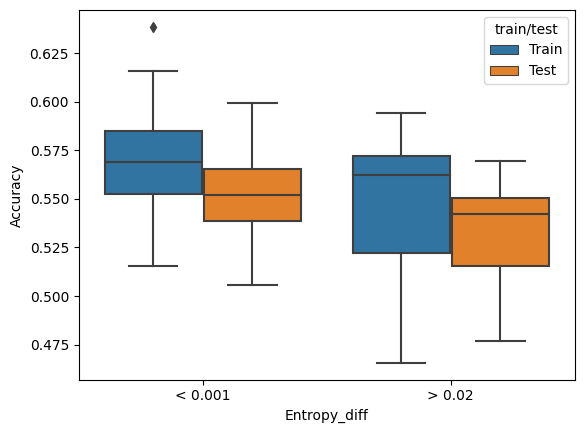

In [30]:
sns.boxplot(data = data, x = "Entropy_diff", y = "Accuracy", hue = "train/test")